In [14]:
import torch as t
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import PIL
from PIL import Image
import json
from pathlib import Path
from typing import Union, Tuple, Callable, Optional
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import utils
import torch.nn as nn
from einops import rearrange, repeat

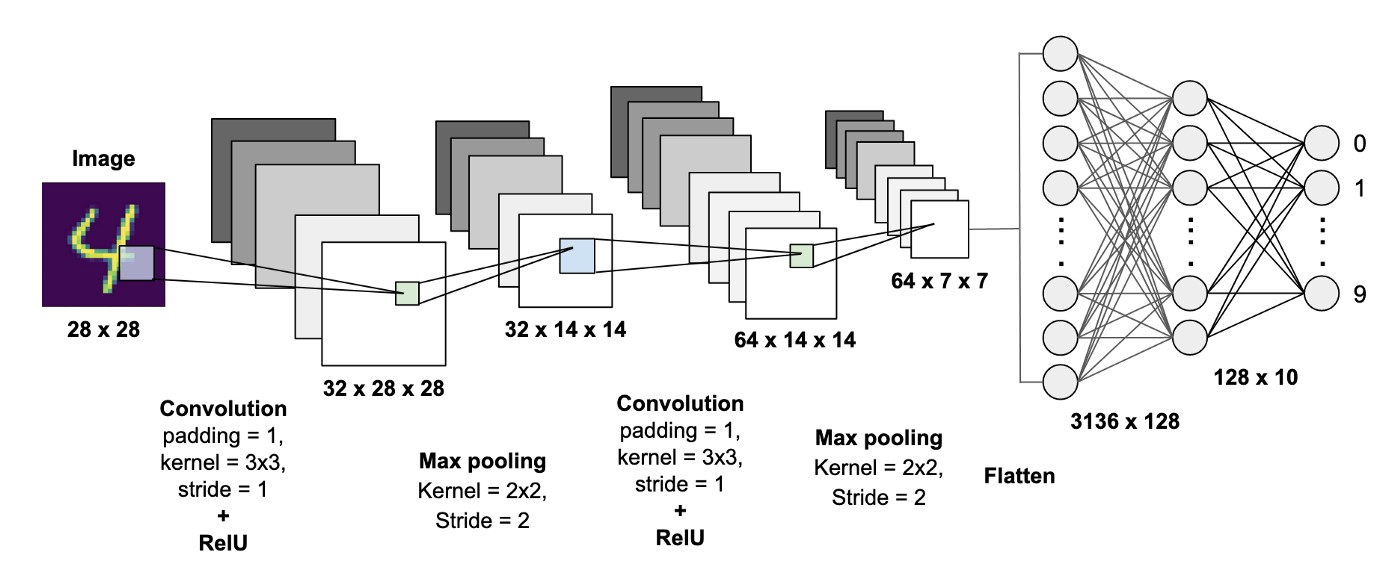

In [6]:
from IPython.display import Image
Image(filename='cnnarch.jpeg')

In [9]:
from torch.nn import Conv2d, Linear, MaxPool2d, ReLU, Sequential
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 32, 3, 1, 1)
        self.conv2 = Conv2d(32, 64, 3, 1, 1)
        self.lin1 = Linear(3136, 128)
        self.lin2 = Linear(128, 10)
        self.pool = MaxPool2d(2,2)

    def forward(self, x: t.Tensor) -> t.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = t.flatten(x, 1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return x

model = ConvNet()
print(model)


ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lin1): Linear(in_features=3136, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

8.6%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%
13.9%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%
100.0%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [21]:
def display_array_as_img(img_array):
    """
    Displays a numpy array as an image
    
    Two options:
        img_array.shape = (height, width) -> interpreted as monochrome
        img_array.shape = (3, height, width) -> interpreted as RGB
    """
    shape = img_array.shape
    assert len(shape) == 2 or (shape[0] == 3 and len(shape) == 3), "Incorrect format (see docstring)"
    
    if len(shape) == 3:
        img_array = rearrange(img_array, "c h w -> h w c")
    height, width = img_array.shape[:2]
    
    fig = px.imshow(img_array, zmin=0, zmax=255, color_continuous_scale='gray')
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(coloraxis_showscale=False, margin=dict.fromkeys("tblr", 0), height=height, width=width)
    fig.show(config=dict(displayModeBar=False))

print(trainset.data[0].shape)
display_array_as_img(repeat(trainset.data[0], 'h w -> (h 5) (w 5)'))

torch.Size([28, 28])


In [31]:
from tqdm.notebook import tqdm_notebook
import time

for i in tqdm_notebook(range(100)):
    time.sleep(0.01)

  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
device = t.device('cuda:0' if t.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)


cpu


In [53]:
epochs = 3
loss_fn = nn.CrossEntropyLoss()
batch_size = 128

MODEL_FILENAME = "./w1d2_convnet_mnist.pt"
device = "cuda" if t.cuda.is_available() else "cpu"
NUM_IMAGES = len(trainset)

def train_convnet(trainloader: DataLoader, epochs: int, loss_fn: Callable) -> list:
    '''
    Defines a ConvNet using our previous code, and trains it on the data in trainloader.
    '''

    model = ConvNet().to(device).train()
    optimizer = t.optim.Adam(model.parameters())
    loss_list = []



    for epoch in tqdm_notebook(range(epochs)):
        correct = 0

        for (x, y) in tqdm_notebook(trainloader, leave=False):

            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            y_predictions = y_hat.argmax(1)
            correct += (y_predictions == y).count_nonzero()
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


            loss_list.append(loss.item())

        print(f"Epoch {epoch+1}/{epochs}, train loss is {loss:.6f}")
        print(f"{correct}/{NUM_IMAGES} correct")
        

    print(f"Saving model to: {MODEL_FILENAME}")
    t.save(model, MODEL_FILENAME)
    return loss_list

loss_list = train_convnet(trainloader, epochs, loss_fn)

fig = px.line(y=loss_list, template="simple_white")
fig.update_layout(title="Cross entropy loss on MNIST", yaxis_range=[0, max(loss_list)])
fig.show()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/3, train loss is 0.752338
34852/60000 correct


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3, train loss is 0.865229
35502/60000 correct


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3, train loss is 0.766835
35607/60000 correct
Saving model to: ./w1d2_convnet_mnist.pt


In [48]:
# see what the model would guess for x

for i in range(3):
    x = trainset.data[i]
    y = trainset.targets[i]
    display_array_as_img(x)
    print(y)

tensor(5)


tensor(0)


tensor(4)


In [50]:
model = t.load(MODEL_FILENAME)
model.eval()

model()

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lin1): Linear(in_features=3136, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [52]:
# # for i in range(3):
# #     x = trainset.data[i]
# #     y = trainset.targets[i]
# #     display_array_as_img(x)
# #     print(y)
# #     print(model(x))

# print(model(trainset.data[:10]))

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 10, 28, 28] to have 1 channels, but got 10 channels instead